# Apply 

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)})
plt.style.use(['seaborn-whitegrid'])

import warnings
warnings.simplefilter('ignore')

import utils

In [2]:
filenames = ['data/measured_real_power.csv',
             'data/measured_reactive_power.csv']

df = utils.read_dir(filenames)
df.shape

(518440, 4)

What is the `real` and `reactive` timeseries for `triplex_meter_5`?

In [3]:
tm5 = df.query("variable=='triplex_meter_5'")
tm5.head()

,timestamp,variable,attribute,value
388830,2013-07-01 00:00:00,triplex_meter_5,measured_reactive_power,128.047
388831,2013-07-01 00:01:00,triplex_meter_5,measured_reactive_power,128.047
388832,2013-07-01 00:02:00,triplex_meter_5,measured_reactive_power,128.047
388833,2013-07-01 00:03:00,triplex_meter_5,measured_reactive_power,128.047
388834,2013-07-01 00:04:00,triplex_meter_5,measured_reactive_power,128.046


Pivot on **attribute**

In [4]:
tm5 = tm5.pivot(index='timestamp', columns='attribute', values='value')

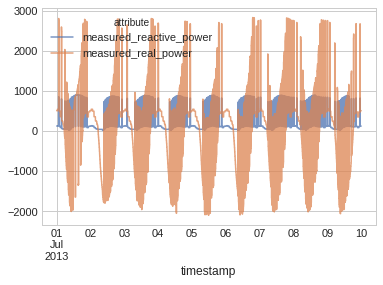

In [5]:
_ = tm5.plot(alpha=0.75)

## The `apply` function 

In [6]:
tm5.head()

attribute,measured_reactive_power,measured_real_power
timestamp,,
2013-07-01 00:00:00,128.047,510.912
2013-07-01 00:01:00,128.047,510.912
2013-07-01 00:02:00,128.047,510.912
2013-07-01 00:03:00,128.047,510.912
2013-07-01 00:04:00,128.046,510.911


In [7]:
def func(x):
    return "just a string {} {}".format(x.shape, type(x))
    
tm5.apply(func, axis=0)  # flip the axis

attribute
measured_reactive_power    just a string (12961,) <class 'pandas.core.ser...
measured_real_power        just a string (12961,) <class 'pandas.core.ser...
dtype: object

In [8]:
tm5.apply(lambda x: "just a string {}".format(", ".join(x.index.values)), axis=1).head()

timestamp
2013-07-01 00:00:00    just a string measured_reactive_power, measure...
2013-07-01 00:01:00    just a string measured_reactive_power, measure...
2013-07-01 00:02:00    just a string measured_reactive_power, measure...
2013-07-01 00:03:00    just a string measured_reactive_power, measure...
2013-07-01 00:04:00    just a string measured_reactive_power, measure...
dtype: object

In [9]:
tmp = tm5.copy()
tmp['func'] = tmp.apply(func, axis=1)
tmp.head()

attribute,measured_reactive_power,measured_real_power,func
timestamp,,,
2013-07-01 00:00:00,128.047,510.912,"just a string (2,) <class 'pandas.core.series...."
2013-07-01 00:01:00,128.047,510.912,"just a string (2,) <class 'pandas.core.series...."
2013-07-01 00:02:00,128.047,510.912,"just a string (2,) <class 'pandas.core.series...."
2013-07-01 00:03:00,128.047,510.912,"just a string (2,) <class 'pandas.core.series...."
2013-07-01 00:04:00,128.046,510.911,"just a string (2,) <class 'pandas.core.series...."


How about the `row` magnitude of `real` and `reactive`?

In [10]:
def row_mag(x):
    return abs(complex(x['measured_real_power'], x['measured_reactive_power']))

tm5.apply(row_mag, axis=1).head()

timestamp
2013-07-01 00:00:00    526.713495
2013-07-01 00:01:00    526.713495
2013-07-01 00:02:00    526.713495
2013-07-01 00:03:00    526.713495
2013-07-01 00:04:00    526.712282
dtype: float64

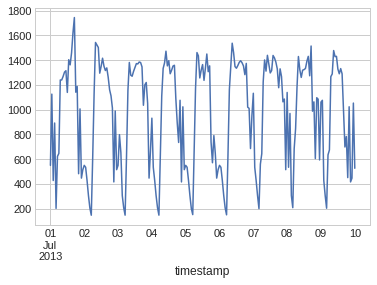

In [11]:
tm5.apply(row_mag, axis=1).resample('60min').mean().plot()

Two other methods

In [12]:
import math

def row_mag_basic(x):
    return math.sqrt(x['measured_real_power']*x['measured_real_power'] + 
                     x['measured_reactive_power']*x['measured_reactive_power'])

def compute_mag(df):
    total =  (df['measured_real_power']*df['measured_real_power'] + 
              df['measured_reactive_power']*df['measured_reactive_power'])
    
    return total.apply(math.sqrt)

We cannot do:
    
```python
        math.sqrt(total)
```
but we can `apply` it.

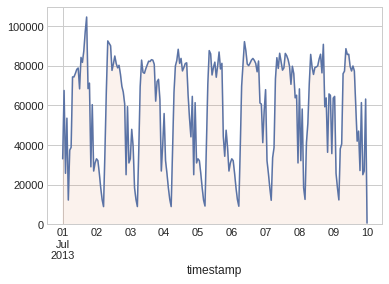

In [13]:
tm5.apply(row_mag, axis=1).resample('60min').sum().plot()
compute_mag(tm5).resample('60min').sum().plot(kind='area', alpha=0.1)

In [14]:
%timeit tm5.apply(row_mag, axis=1)

379 ms ± 4.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit tm5.apply(row_mag_basic, axis=1)

684 ms ± 29.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit compute_mag(tm5)

2.72 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Pandas stores data in `column-wise` numpy arrays.